# Introduction

The following Exploratory Data Analysis (EDA) is intended to provide insight into the distributions and possible patterns in the data.

# Import Libraries and Other Code

In [13]:
# Relevant Libraries

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import re

from typing import Callable

In [14]:
def PlotDistributionByTarget(Dataset:pd.DataFrame,Features:list[str],Target:str,TypePlot:Callable,FeatureTypeName:str,AdditionalPlotArgs:dict={}) -> None:
    """
        Function for plotting distribution of features 
        by value of target
    """
    mosaic_grid = "1122\n.33."
    fig , axes = plt.subplot_mosaic(mosaic_grid,figsize=(8,6),layout='tight')

    for index_axes , feature in enumerate(Features,1):
        axes_plot = axes[str(index_axes)]
        TypePlot(Dataset,x=feature,hue=Target,palette=['lightgreen','green'],ax=axes_plot,legend=False,**AdditionalPlotArgs)
        axes_plot.set_xlabel(re.sub(r'_',' ',feature))

    fig.suptitle(f'Distribution of {FeatureTypeName} Features')
    fig.legend(title='Growth Milestone',labels=['No Milestone','Milestone'],loc=(0.05,0.35))

# Load Dataset and First Exploration

In [2]:
# Loading dataset

PlantGrowth_Dataset = pd.read_csv("plant_growth_data.csv")

print(f'Dataset shape is: {PlantGrowth_Dataset.shape}')

# Example of records
PlantGrowth_Dataset.head(5)

Dataset shape is: (193, 7)


,Soil_Type,Sunlight_Hours,Water_Frequency,Fertilizer_Type,Temperature,Humidity,Growth_Milestone
0,loam,5.192294,bi-weekly,chemical,31.719602,61.591861,0
1,sandy,4.033133,weekly,organic,28.919484,52.422276,1
2,loam,8.892769,bi-weekly,none,23.179059,44.660539,0
3,loam,8.241144,bi-weekly,none,18.465886,46.433227,0
4,sandy,8.374043,bi-weekly,organic,18.128741,63.625923,0


In [3]:
# Data types of variables

PlantGrowth_Dataset.dtypes

Soil_Type            object
Sunlight_Hours      float64
Water_Frequency      object
Fertilizer_Type      object
Temperature         float64
Humidity            float64
Growth_Milestone      int64
dtype: object

In [4]:
# Splitting variables into numerical and categorical

labels_variables = PlantGrowth_Dataset.columns

Features = labels_variables[:-1]
Target = labels_variables[-1]

NumericalFeatures , CategoricalFeatures = [] , []
for feature in Features:
    if PlantGrowth_Dataset[feature].dtype == 'object':
        CategoricalFeatures.append(feature)
    else:
        NumericalFeatures.append(feature)

In [5]:
# Basic descriptive : Numerical features

PlantGrowth_Dataset[NumericalFeatures].describe()

,Sunlight_Hours,Temperature,Humidity
count,193.000000,193.000000,193.000000
mean,6.826484,25.076087,58.098927
std,1.599509,5.354170,12.631799
min,4.033133,15.200000,30.567682
25%,5.477000,20.637095,49.300000
50%,6.833290,25.912336,59.182806
75%,8.241144,29.757938,69.100000
max,9.913903,34.810103,79.648240


In [6]:
# Basic descriptive : Categorical features

PlantGrowth_Dataset[CategoricalFeatures].describe()

,Soil_Type,Water_Frequency,Fertilizer_Type
count,193,193,193
unique,3,3,3
top,clay,daily,none
freq,67,74,74


# Distribution of Features

From the plots, it can be seen that the attributes follow different distributions, although there is some overlapping, making there a certain tendency (in the attributes) at the moment of evaluating whether there is significant growth.

Noting that for significant growth to occur the hours of sunlight and humidity must be in an optimal range, in addition to fertilizer being used on the plant.

## Numerical Features

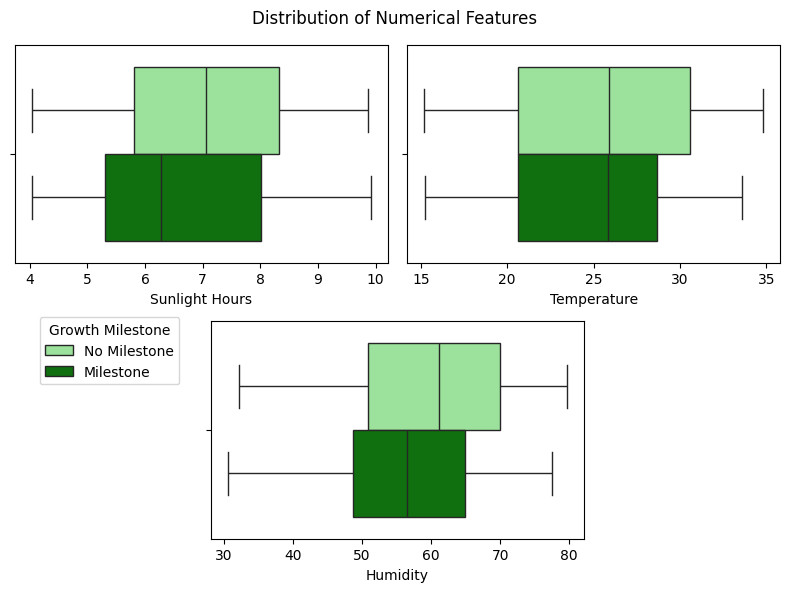

In [15]:
PlotDistributionByTarget(PlantGrowth_Dataset,NumericalFeatures,Target,sns.boxplot,'Numerical')

## Categorical Features

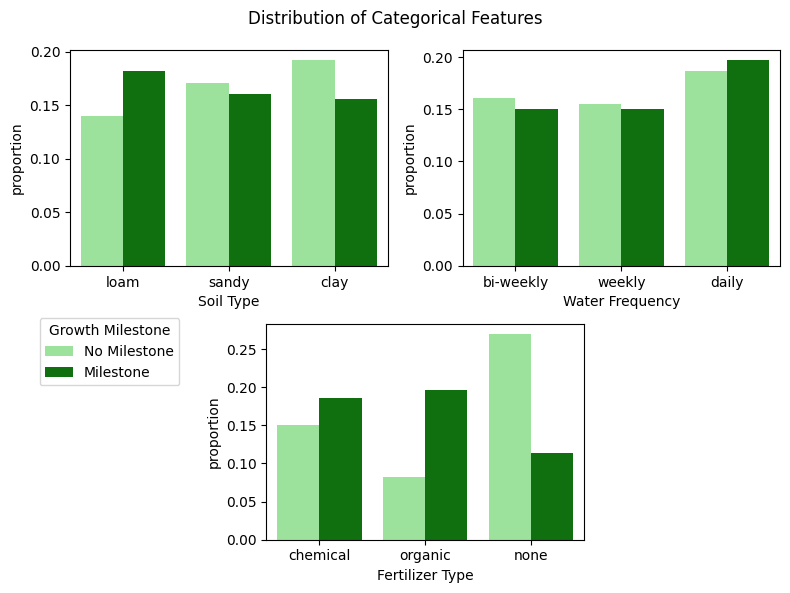

In [17]:
PlotDistributionByTarget(PlantGrowth_Dataset,CategoricalFeatures,Target,sns.countplot,'Categorical',{'stat':'proportion'})

# Correlations

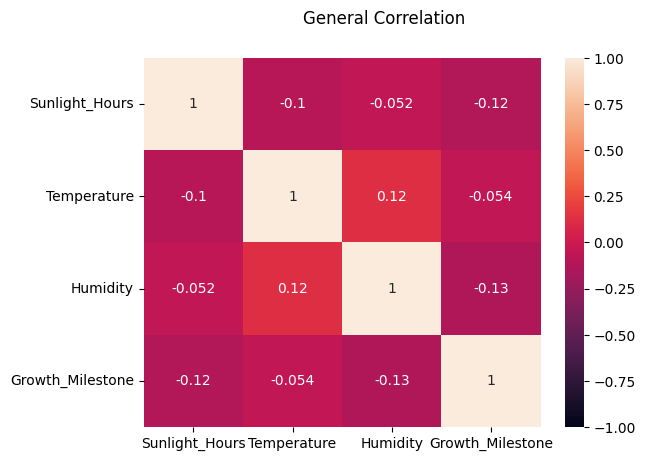

In [9]:
fig , axes = plt.subplots()

numerical_dataset = PlantGrowth_Dataset[NumericalFeatures+[Target]].copy()
correlation_matrix = numerical_dataset.corr()
sns.heatmap(correlation_matrix,vmin=-1,vmax=1,annot=True,ax=axes)

fig.suptitle('General Correlation');

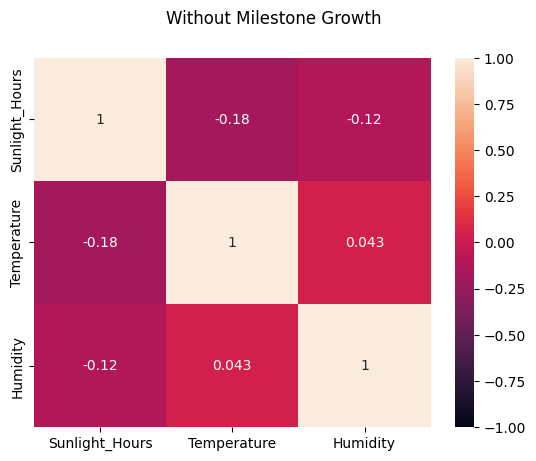

In [10]:
fig , axes = plt.subplots()

numerical_dataset = PlantGrowth_Dataset.query("Growth_Milestone == 0")[NumericalFeatures].copy()
correlation_matrix = numerical_dataset.corr()
sns.heatmap(correlation_matrix,vmin=-1,vmax=1,annot=True,ax=axes)

fig.suptitle('Without Milestone Growth');

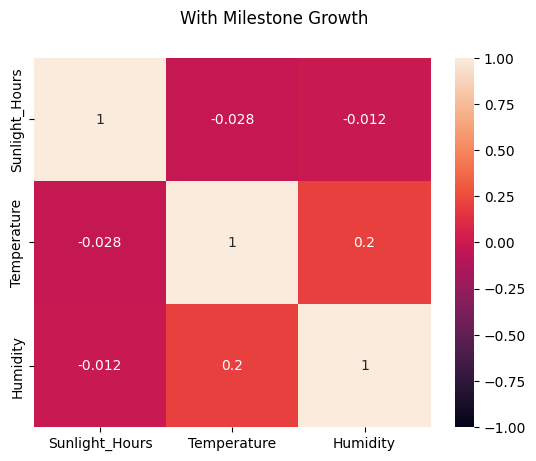

In [11]:
fig , axes = plt.subplots()

numerical_dataset = PlantGrowth_Dataset.query("Growth_Milestone == 1")[NumericalFeatures].copy()
correlation_matrix = numerical_dataset.corr()
sns.heatmap(correlation_matrix,vmin=-1,vmax=1,annot=True,ax=axes)

fig.suptitle('With Milestone Growth');